Copyright **`(c)`** 2023 Florentin-Cristian Udrea `<udrea.florentin00@gmail.com>` 

[`https://github.com/florentin1304/computational-intelligence`](https://github.com/florentin1304/computational-intelligence)

# LAB10

Use reinforcement learning to devise a tic-tac-toe player.

### Deadlines:

* Submission: [Dies Natalis Solis Invicti](https://en.wikipedia.org/wiki/Sol_Invictus)
* Reviews: [Befana](https://en.wikipedia.org/wiki/Befana)

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

# Requirements and imports

After installing the requirements file a restart of the kernel may be needed for the install to take place!

In [1]:
# pip install -r requirements.txt

In [2]:
import gym_TicTacToe
import gym
import numpy as np
from IPython.display import clear_output
from agent import TicTacToeAgent
import tqdm
import matplotlib.pyplot as plt


# Agent Training 

### Enemy player

The enemy player is chosen within the environment and, after every move of the agent, the gym makes the enemy move implicitly. In this case the enemy player is simply a random player that always plays one of the valid moves left.

### Epsilon policy
It will balance the exploration-eploitation tradeoff by using a $\epsilon$-greedy policy. The $\epsilon$ is decaying as follows:

$$ \epsilon = {b \over b + ep_{n}} $$

Where b is a constant that depends on the minimum $\epsilon_{min}$ desired and the episode at which the minimum $\epsilon$ is wanted to be encountered at ($ep_n^*$), described as follows:

$$ b = { \epsilon_{min} \over (1 - \epsilon_{min})} ep_n^* $$


In [ ]:
# initialize the tictactoe environment
env = gym.envs.make("TTT-v0", small=-0.1, large=20)

In [3]:
episodes = 2_000_000
agent = TicTacToeAgent(num_of_actions=env.action_space.n, 
                        gamma=0.98, 
                        lr=0.01, 
                        epsilon_min=0.05, 
                        epsilon_min_episode_reached=episodes)
agent.train()
test = False
talk_every = 5000

ep_rewards, epl_avg, perc_wins, epsilon_hist = [], [], [], []
for ep in tqdm.tqdm(range(episodes)):
    state, info, done, steps = *env.reset(adversary_first=np.random.choice([True, False])), False, 0
    
    agent.update_epsilon(ep)
    turn = 0
    sum_reward = 0
    
    while not done:
        action = agent.get_action(state)
        new_state, reward, done, info = env.step(action)

        if not test:
            agent.learn(state, action, new_state, reward, done)#, talk=(done and reward>0))
        else:
            env.render()

            
        state = new_state
        sum_reward += reward
        steps += 1

    ep_rewards.append(sum_reward)
    epl_avg.append(np.mean(ep_rewards[ max(0, ep-talk_every) : ]))
    perc_wins.append((np.sum(np.array(ep_rewards[max(0, ep-talk_every):]) > 0 )/talk_every) * 100)
    epsilon_hist.append(agent.epsilon)
    
    if (ep+1) % talk_every == 0:
        clear_output(wait=True)
        print("="*22, "Training resume", "="*22)
        print(f"Episode {ep+1}, average reward: { np.mean(ep_rewards[max(0, ep-talk_every):]) :.2f}")
        print(f"Perc. wins:  {(np.sum(np.array(ep_rewards[max(0, ep-talk_every):]) > 0 )/talk_every) * 100:.4}")
        print(f"Epsilon: {agent.epsilon:.4}")
        print(f"Len QTable: {len(agent.q_table)}")
        print("="*61, end='\r', flush=True)

agent.q_table.save_csv("agent_qtable.csv")

====================== Training resume ======================
Episode 2000000, average reward: 16.62
Perc. wins:  90.18
Epsilon: 0.05
Len QTable: 5478


100%|██████████| 2000000/2000000 [31:03<00:00, 1073.33it/s]


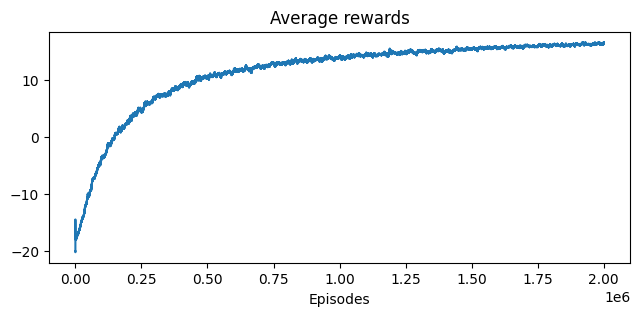

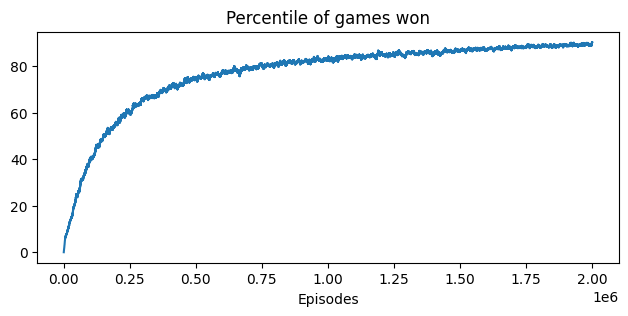

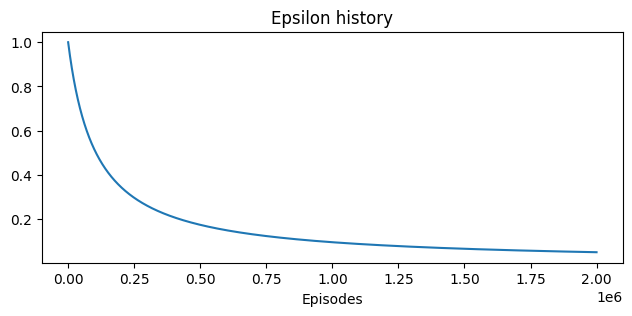

In [14]:
plt.rcParams['figure.figsize'] = (7.5, 3)

plt.xlabel("Episodes")
plt.title("Average rewards")
plt.plot(epl_avg, label="Average rewards")
plt.show()

plt.xlabel("Episodes")
plt.title("Percentile of games won")
plt.plot(perc_wins, label="Perc.wins")
plt.show()

plt.xlabel("Episodes")
plt.title("Epsilon history")
plt.plot(epsilon_hist, label="")
plt.show()


# Agent Testing

After the training is done, a file `agent_qtable.csv` is created. It contains the optimal q-table found during the training.

If the agent has to be tested (or deployed in any other way) the following two lines of code have to be executed:

`agent.q_table.load_csv("agent_qtable.csv")`

`agent.test()`

Where the first loads the optimal q-values in the agent's q-table, while the second puts the agent in test mode, meaning it will always take the greedy action, no mather the current epsilon.

In [8]:
episodes = 10_000
agent = TicTacToeAgent(num_of_actions=env.action_space.n, 
                        gamma=0.98, 
                        lr=0.01, 
                        epsilon_min=0.1, 
                        epsilon_min_episode_reached=episodes)
agent.q_table.load_csv("agent_qtable.csv")
agent.test()
test = False
talk_every = 5000

test_ep_rewards, test_epl_avg, test_perc_wins = [], [], []
for ep in tqdm.tqdm(range(episodes)):
    state, info, done, steps = *env.reset(adversary_first=np.random.choice([True, False])), False, 0
    
    agent.update_epsilon(ep)
    turn = 0
    sum_reward = 0
    
    while not done:
        action = agent.get_action(state)
        new_state, reward, done, info = env.step(action)
        state = new_state
        sum_reward += reward
        steps += 1

    test_ep_rewards.append(sum_reward)
    test_epl_avg.append(np.mean(test_ep_rewards[ max(0, ep-talk_every) : ]))
    test_perc_wins.append((np.sum(np.array(test_ep_rewards[max(0, ep-talk_every):]) > 0 )/talk_every) * 100)
    
    if (ep+1) % talk_every == 0:
        clear_output(wait=True)
        print("="*22, "Testing resume", "="*22)
        print(f"Episode {ep+1}, average reward: { np.mean(test_ep_rewards[max(0, ep-talk_every):]) :.2f}")
        print(f"Perc. wins:  {(np.sum(np.array(test_ep_rewards[max(0, ep-talk_every):]) > 0 )/talk_every) * 100:.4}")
        print("="*61, end='\r', flush=True)

====================== Testing resume ======================
Episode 10000, average reward: 19.44
Perc. wins:  98.84


100%|██████████| 10000/10000 [00:07<00:00, 1277.79it/s]


# Game display

In [31]:
adversary_first = np.random.choice([True, False])
print(f"{adversary_first=}")
state, info, done, steps = *env.reset(adversary_first=adversary_first), False, 0
print(env.render())

turn = 0
sum_reward = 0

while not done:
    action = agent.get_action(state)
    new_state, reward, done, info = env.step(action)
    state = new_state
    sum_reward += reward
    steps += 1
    print(env.render())

adversary_first=True
╒═══╤═══╤═══╕
│ - │ - │ - │
├───┼───┼───┤
│ - │ - │ - │
├───┼───┼───┤
│ - │ - │ X │
╘═══╧═══╧═══╛
╒═══╤═══╤═══╕
│ - │ - │ - │
├───┼───┼───┤
│ - │ O │ X │
├───┼───┼───┤
│ - │ - │ X │
╘═══╧═══╧═══╛
╒═══╤═══╤═══╕
│ - │ - │ O │
├───┼───┼───┤
│ - │ O │ X │
├───┼───┼───┤
│ X │ - │ X │
╘═══╧═══╧═══╛
╒═══╤═══╤═══╕
│ - │ X │ O │
├───┼───┼───┤
│ - │ O │ X │
├───┼───┼───┤
│ X │ O │ X │
╘═══╧═══╧═══╛
╒═══╤═══╤═══╕
│ O │ X │ O │
├───┼───┼───┤
│ X │ O │ X │
├───┼───┼───┤
│ X │ O │ X │
╘═══╧═══╧═══╛
